# Evaluating performance

This file applies the strategy from `wordle_solver.ipynb` to all possible words and creates histograms to show the results. 

For efficiency, `performance.ipynb` pre-computes and cache all possible measurements of word pairs (in `WORD_SCORES`), and work with the indices of the words in the `ALL_WORDS` list, rather than the words themselves. This improves efficiency significantly as we run the strategy repeatedly on all words in the dictionary.

In [2]:
# for prop, freqtable
using FreqTables
# for mean
using Statistics
include("utils.jl");

In [3]:
@time begin
    for (i1, w1) in enumerate(ALL_WORDS)
        for (i2, w2) in enumerate(ALL_WORDS)
            WORD_SCORES[i1, i2] = get_word_score(w1, w2)
        end
    end
end

127.606711 seconds (2.17 G allocations: 117.657 GiB, 12.27% gc time, 0.01% compilation time)


### Using only solution words as guesses, prioritizing entropy

In [4]:
turns_sol_ent = get_num_turns(SOLUTION_WORD_IDXS, SOLUTION_WORD_IDXS, heuristic=PRIORITIZE_ENTROPY);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


First guess: raise
 31.816169 seconds (801.63 M allocations: 24.230 GiB, 11.30% gc time, 6.09% compilation time)


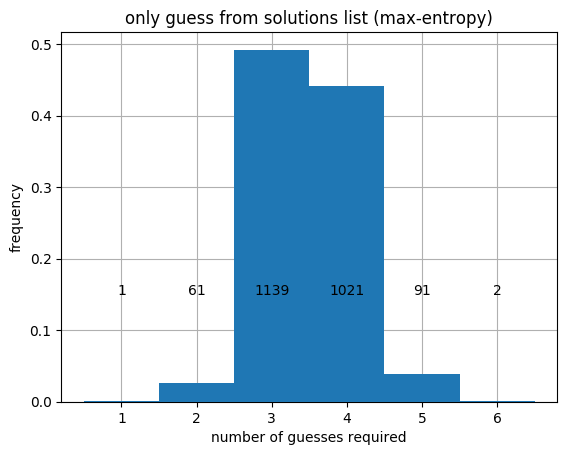

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/vtjeng/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [5]:
plot_num_turns(
    turns_sol_ent,
    title_text="only guess from solutions list (max-entropy)",
    saved_filename="strat_using_solutions_only_prioritize_entropy.png"
)

In [6]:
prop(freqtable(turns_sol_ent))

6-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0263499
3     │    0.492009
4     │    0.441037
5     │   0.0393089
6     │ 0.000863931

In [7]:
Statistics.mean(turns_sol_ent)

3.4950323974082074

### Using only solution words as guesses, prioritizing maxsize

In [8]:
turns_sol = get_num_turns(SOLUTION_WORD_IDXS, SOLUTION_WORD_IDXS, heuristic=PRIORITIZE_MAX_GROUP_SIZE);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:29


First guess: raise
 29.561079 seconds (802.12 M allocations: 24.252 GiB, 12.31% gc time)


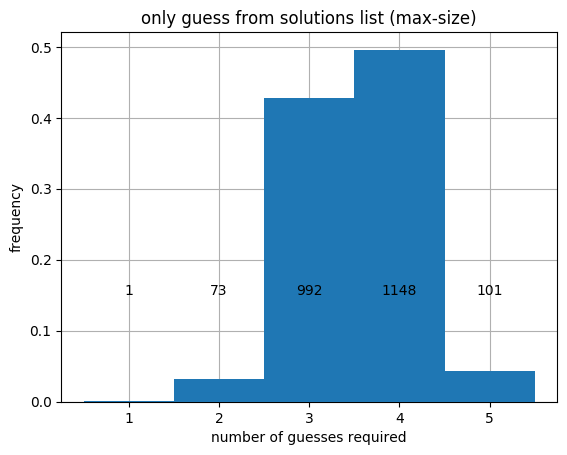

In [9]:
plot_num_turns(
    turns_sol,
    title_text="only guess from solutions list (max-size)",
    saved_filename="strat_using_solutions_only.png"
)

In [10]:
prop(freqtable(turns_sol))

5-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0315335
3     │     0.42851
4     │    0.495896
5     │   0.0436285

In [11]:
Statistics.mean(turns_sol)

3.550755939524838

### Using only solution words as guesses, prioritizing max splits

In [38]:
turns_sol_split = get_num_turns(SOLUTION_WORD_IDXS, SOLUTION_WORD_IDXS, heuristic=PRIORITIZE_SPLITS);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


First guess: trace
 32.464975 seconds (909.01 M allocations: 27.019 GiB, 11.21% gc time)


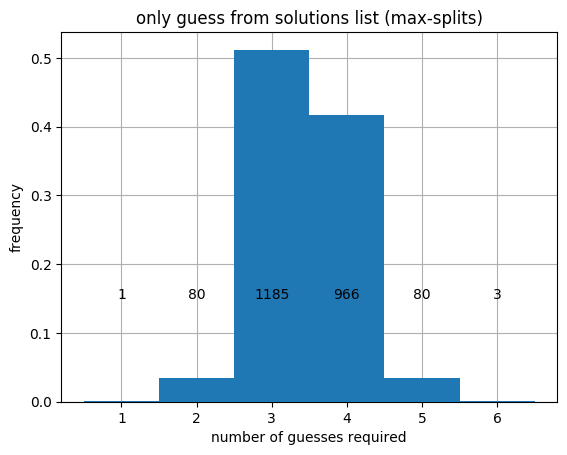

In [39]:
plot_num_turns(
    turns_sol_split,
    title_text="only guess from solutions list (max-splits)",
    saved_filename="strat_using_solutions_only_prioritize_splits.png"
)

In [40]:
prop(freqtable(turns_sol_split))

6-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0345572
3     │    0.511879
4     │    0.417279
5     │   0.0345572
6     │   0.0012959

In [41]:
Statistics.mean(turns_sol_split)

3.4548596112311016

### Using all possible words as guesses, prioritizing entropy

In [12]:
turns_all_ent = get_num_turns(ALL_WORD_IDXS, SOLUTION_WORD_IDXS, heuristic=PRIORITIZE_ENTROPY);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:37


First guess: soare
157.814336 seconds (4.83 G allocations: 137.247 GiB, 11.95% gc time)


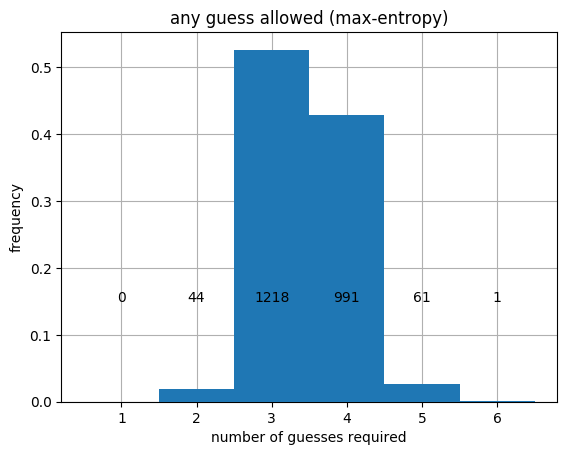

In [13]:
plot_num_turns(
    turns_all_ent,
    title_text="any guess allowed (max-entropy)",
    saved_filename="strat_using_any_guess_prioritize_entropy.png"
)

In [14]:
prop(freqtable(turns_all_ent))

5-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
2     │   0.0190065
3     │    0.526134
4     │    0.428078
5     │   0.0263499
6     │ 0.000431965

In [15]:
Statistics.mean(turns_all_ent)

3.4630669546436286

### Using all possible words as guesses, prioritizing maxsize

In [16]:
turns_all = get_num_turns(ALL_WORD_IDXS, SOLUTION_WORD_IDXS, heuristic=PRIORITIZE_MAX_GROUP_SIZE);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:37


First guess: raise
157.426804 seconds (4.78 G allocations: 138.237 GiB, 12.04% gc time)


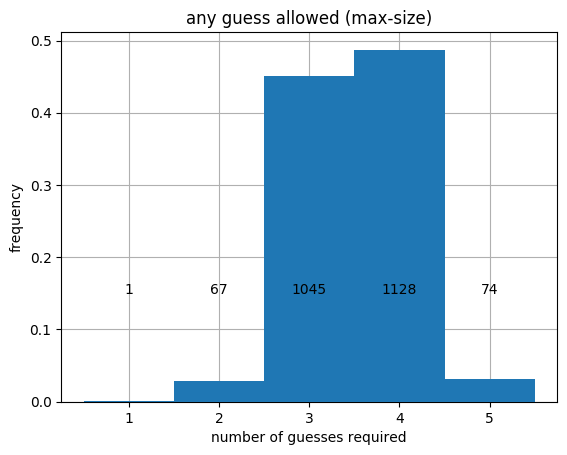

In [17]:
plot_num_turns(
    turns_all,
    title_text="any guess allowed (max-size)",
    saved_filename="strat_using_any_guess.png"
)

In [18]:
prop(freqtable(turns_all))

5-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0289417
3     │    0.451404
4     │    0.487257
5     │   0.0319654

In [19]:
Statistics.mean(turns_all)

3.5213822894168465

### Using all possible words as guesses, prioritizing max splits

In [42]:
turns_all_split = get_num_turns(ALL_WORD_IDXS, SOLUTION_WORD_IDXS, heuristic=PRIORITIZE_SPLITS);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:02


First guess: trace
182.149518 seconds (5.47 G allocations: 156.887 GiB, 11.59% gc time)


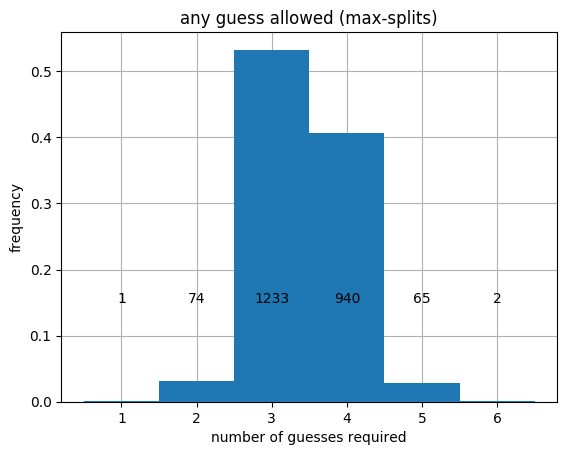

In [43]:
plot_num_turns(
    turns_all_split,
    title_text="any guess allowed (max-splits)",
    saved_filename="strat_using_any_guess_prioritize_splits.png"
)

In [44]:
prop(freqtable(turns_all_split))

6-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0319654
3     │    0.532613
4     │    0.406048
5     │   0.0280778
6     │ 0.000863931

In [45]:
Statistics.mean(turns_all_split)

3.4319654427645787

### Using only solutions words as guesses + hard mode, prioritizing entropy

In [20]:
turns_hard_ent = get_num_turns(SOLUTION_WORD_IDXS, SOLUTION_WORD_IDXS, heuristic=PRIORITIZE_ENTROPY, hard_mode = true);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


First guess: raise
  1.670778 seconds (42.02 M allocations: 874.289 MiB, 6.51% gc time)


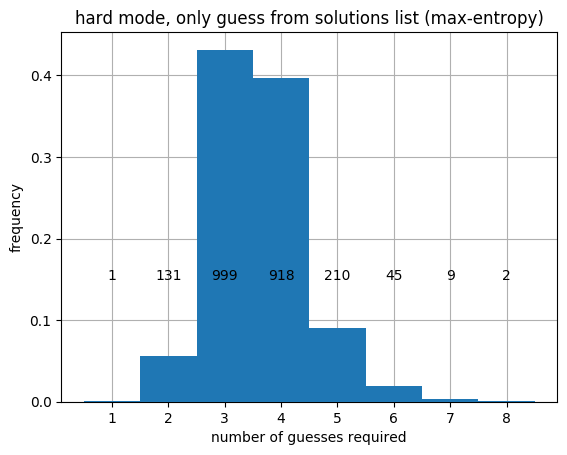

In [21]:
plot_num_turns(
    turns_hard_ent,
    title_text="hard mode, only guess from solutions list (max-entropy)",
    saved_filename="strat_using_hard_mode_prioritize_entropy.png"
)

In [22]:
prop(freqtable(turns_hard_ent))

8-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0565875
3     │    0.431533
4     │    0.396544
5     │   0.0907127
6     │   0.0194384
7     │  0.00388769
8     │ 0.000863931

In [23]:
Statistics.mean(turns_hard_ent)

3.5987041036717065

### Using only solutions words as guesses + hard mode, prioritizing maxsize

In [24]:
turns_hard = get_num_turns(SOLUTION_WORD_IDXS, SOLUTION_WORD_IDXS, heuristic=PRIORITIZE_MAX_GROUP_SIZE, hard_mode = true);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


First guess: raise
  1.749165 seconds (43.39 M allocations: 934.346 MiB, 7.44% gc time, 1.41% compilation time)


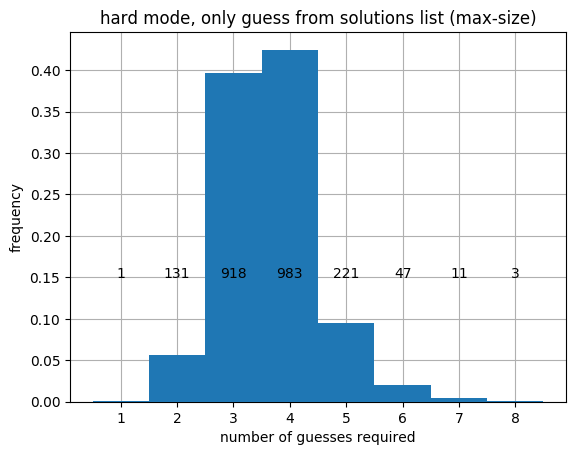

In [25]:
plot_num_turns(
    turns_hard,
    title_text="hard mode, only guess from solutions list (max-size)",
    saved_filename="strat_using_hard_mode.png"
)

In [26]:
prop(freqtable(turns_hard))

8-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0565875
3     │    0.396544
4     │    0.424622
5     │   0.0954644
6     │   0.0203024
7     │  0.00475162
8     │   0.0012959

In [27]:
Statistics.mean(turns_hard)

3.6444924406047514

### Using only solutions words as guesses + hard mode, prioritizing max splits

In [52]:
turns_hard_split = get_num_turns(SOLUTION_WORD_IDXS, SOLUTION_WORD_IDXS, heuristic=PRIORITIZE_SPLITS, hard_mode = true);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


First guess: trace
  2.236405 seconds (52.48 M allocations: 1.197 GiB, 5.23% gc time)


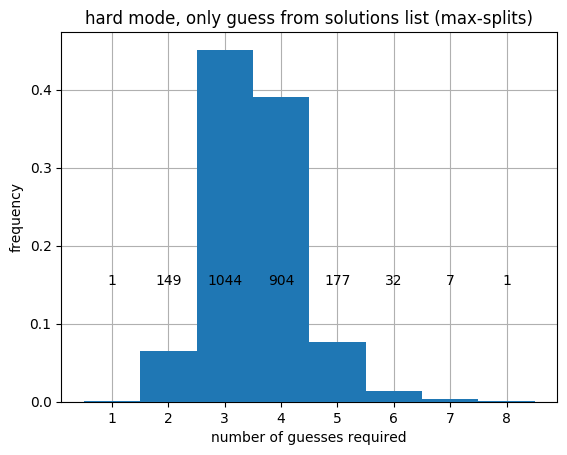

In [53]:
plot_num_turns(
    turns_hard_split,
    title_text="hard mode, only guess from solutions list (max-splits)",
    saved_filename="strat_using_hard_mode_prioritize_splits.png"
)

In [54]:
prop(freqtable(turns_hard_split))

8-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0643629
3     │    0.450972
4     │    0.390497
5     │   0.0764579
6     │   0.0138229
7     │  0.00302376
8     │ 0.000431965

In [55]:
Statistics.mean(turns_hard_split)

3.5339092872570195

### Using all possible words as guesses + hard mode, prioritizing entropy

In [68]:
turns_hard_all_ent = get_num_turns(ALL_WORD_IDXS, SOLUTION_WORD_IDXS, heuristic=PRIORITIZE_ENTROPY, hard_mode = true);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


First guess: soare
  6.799612 seconds (184.31 M allocations: 3.675 GiB, 5.82% gc time)


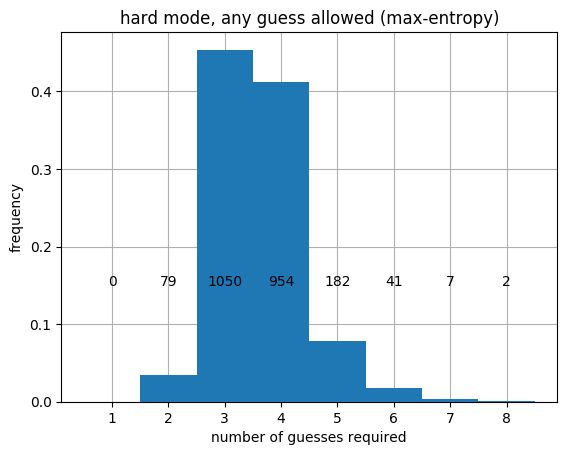

In [69]:
plot_num_turns(
    turns_hard_all_ent,
    title_text="hard mode, any guess allowed (max-entropy)",
    saved_filename="strat_using_hard_mode_any_guess_prioritize_entropy.png"
)

In [70]:
prop(freqtable(turns_hard_all_ent))

7-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
2     │   0.0341253
3     │    0.453564
4     │    0.412095
5     │   0.0786177
6     │   0.0177106
7     │  0.00302376
8     │ 0.000863931

In [71]:
Statistics.mean(turns_hard_all_ent)

3.6047516198704104

### Using all possible words as guesses + hard mode, prioritizing maxsize

In [76]:
turns_hard_all = get_num_turns(ALL_WORD_IDXS, SOLUTION_WORD_IDXS, heuristic=PRIORITIZE_MAX_GROUP_SIZE, hard_mode = true);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


First guess: raise
  7.084129 seconds (188.14 M allocations: 3.926 GiB, 6.11% gc time)


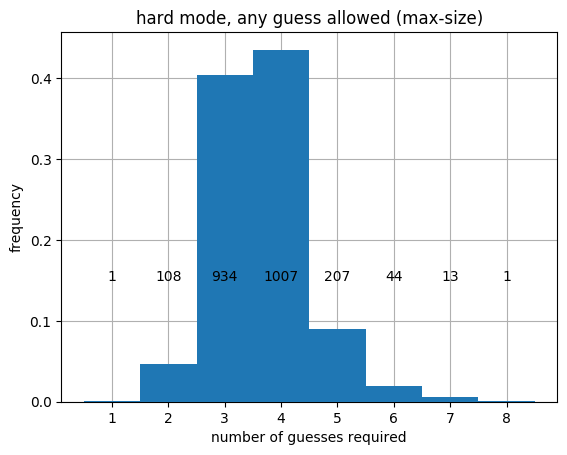

In [77]:
plot_num_turns(
    turns_hard_all,
    title_text="hard mode, any guess allowed (max-size)",
    saved_filename="strat_using_hard_mode_any_guess.png"
)

In [78]:
prop(freqtable(turns_hard_all))

8-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000431965
2     │   0.0466523
3     │    0.403456
4     │    0.434989
5     │   0.0894168
6     │   0.0190065
7     │  0.00561555
8     │ 0.000431965

In [79]:
Statistics.mean(turns_hard_all)

3.647948164146868

### Using all possible words as guesses + hard mode, prioritizing max splits

In [ ]:
turns_hard_all_split = get_num_turns(ALL_WORD_IDXS, SOLUTION_WORD_IDXS, heuristic=PRIORITIZE_SPLITS, hard_mode = true);

Progress:  42%|█████████████████▎                       |  ETA: 0:00:08

In [ ]:
plot_num_turns(
    turns_hard_all_split,
    title_text="any guess allowed (max-splits)",
    saved_filename="strat_using_any_guess_prioritize_splits.png"
)

In [ ]:
prop(freqtable(turns_hard_all_split))

In [ ]:
Statistics.mean(turns_hard_all_split)